In [1]:
import logging
import os
from pathlib import Path

import ml_collections
import torchvision.transforms as transforms
from git import Repo
from pytorch_hyperlight.utils.image_utils import (
    load_image_as_resized_tensor,
    save_image_tensor_to_url,
    show_image_tensors,
)
from pytorch_hyperlight.utils.request_utils import copy_urls_to_files

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
FAST_DEV_RUN = False
CONTENT_IMAGE_PATH_OR_URL = "https://images.unsplash.com/photo-1541426062085-72349d82d048?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=evgeni-tcherkasski-tXFP68P6OGk-unsplash.jpg"
STYLED_IMAGE_PATH_OR_URL = "./styled_image.png"
TARGET_IMAGE_HEIGHT = 400
MODEL_NAME = "style_ukiyoe"

In [4]:
SUPPORTED_MODELS = [
    "summer2winter_yosemite",
    "winter2summer_yosemite",
    "style_monet",
    "style_cezanne",
    "style_ukiyoe",
    "style_vangogh",
]

In [5]:
assert MODEL_NAME in SUPPORTED_MODELS, f"model {MODEL_NAME} is not supported"

In [6]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()

WORKBOOK_DIR = Path(workbookDir)

In [7]:
logging.info(f"WORKBOOK_DIR = {WORKBOOK_DIR}")

INFO:root:WORKBOOK_DIR = /home/peter/_Git/_ML/_DLSchool/dls-style-telegram-bot/ml_server


In [8]:
DGAN_GIT_REPO_URL = "https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix"
PRETRAIND_MODEL_SOURCE_URL = (
    "http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models"
)

In [9]:
GAN_REPO_DIR = WORKBOOK_DIR / "pytorch-CycleGAN-and-pix2pix"

In [10]:
if not GAN_REPO_DIR.is_dir():
    Repo.clone_from(DGAN_GIT_REPO_URL, GAN_REPO_DIR)
else:
    logging.info(f"GAN_REPO_DIR = {GAN_REPO_DIR} already exists")

INFO:root:GAN_REPO_DIR = /home/peter/_Git/_ML/_DLSchool/dls-style-telegram-bot/ml_server/pytorch-CycleGAN-and-pix2pix already exists


In [11]:
os.chdir(GAN_REPO_DIR)
from data import create_dataset
from models import create_model

In [12]:
PRETRAINED_MODEL_DIR = GAN_REPO_DIR / "checkpoints"

In [13]:
logging.basicConfig(level=logging.INFO)

In [14]:
Path.mkdir(PRETRAINED_MODEL_DIR, exist_ok=True)

In [15]:
for model in SUPPORTED_MODELS:
    model_dir = PRETRAINED_MODEL_DIR / f"{model}_pretrained"
    Path.mkdir(model_dir, exist_ok=True)
    model_file = model_dir / "latest_net_G.pth"
    if model_file.exists():
        logging.info(f"model {model} already downloaded")
    else:
        source_url = PRETRAIND_MODEL_SOURCE_URL + f"/{model}.pth"
        msg = f"downloading {model} from {source_url}"
        logging.info(msg + "...")
        if model_file.exists():
            logging.info(f"model {model_file} is already downloaded")
        else:
            copy_urls_to_files(source_url, model_file)
        logging.info(msg + ": done")

INFO:root:model summer2winter_yosemite already downloaded
INFO:root:model winter2summer_yosemite already downloaded
INFO:root:model style_monet already downloaded
INFO:root:model style_cezanne already downloaded
INFO:root:model style_ukiyoe already downloaded
INFO:root:model style_vangogh already downloaded


In [16]:
opt_dict = {
    "checkpoints_dir": PRETRAINED_MODEL_DIR,
    "epoch": "latest",
    "gpu_ids": [0],
    "init_gain": 0.02,
    "init_type": "normal",
    "input_nc": 3,
    "isTrain": False,
    "load_iter": 0,
    "model": "test",
    "model_suffix": "",
    "name": MODEL_NAME + "_pretrained",
    "netG": "resnet_9blocks",
    "ngf": 64,
    "no_dropout": True,
    "norm": "instance",
    "output_nc": 3,
    "preprocess": "resize_and_crop",
    "verbose": False,
}

In [17]:
NORMALIZE_MEAN_LIST = (0.5, 0.5, 0.5)
NORMALIZE_STD_LIST = (0.5, 0.5, 0.5)

In [18]:
class Denormalize(transforms.Normalize):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        std_inv = [1 / (x + 1e-7) for x in self.std]
        mean_inv = [-x * s for x, s in zip(self.mean, std_inv)]
        self.mean = mean_inv
        self.std = std_inv

    def __call__(self, tensor):
        return super().__call__(tensor).clip(0, 1)

In [19]:
DENORMALIZE_T = Denormalize(NORMALIZE_MEAN_LIST, NORMALIZE_STD_LIST)
NORMALIZE_T = transforms.Normalize(NORMALIZE_MEAN_LIST, NORMALIZE_STD_LIST)

In [20]:
opt = ml_collections.ConfigDict(opt_dict)

In [21]:
content_image_tensor = load_image_as_resized_tensor(
    CONTENT_IMAGE_PATH_OR_URL, image_size=TARGET_IMAGE_HEIGHT
)

In [22]:
A = NORMALIZE_T(content_image_tensor).unsqueeze(0)

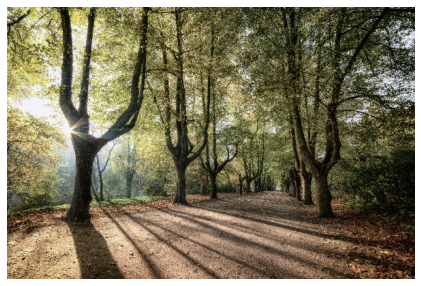

In [23]:
show_image_tensors(content_image_tensor)

In [24]:
model = create_model(opt)
model.setup(opt)
model.eval()
model.set_input({"A": A, "A_paths": ""})
model.test()
visuals = model.get_current_visuals()

initialize network with normal
model [TestModel] was created
loading the model from /home/peter/_Git/_ML/_DLSchool/dls-style-telegram-bot/ml_server/pytorch-CycleGAN-and-pix2pix/checkpoints/style_ukiyoe_pretrained/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.378 M
-----------------------------------------------


In [25]:
styled_image_tensor = DENORMALIZE_T(visuals["fake"].cpu())

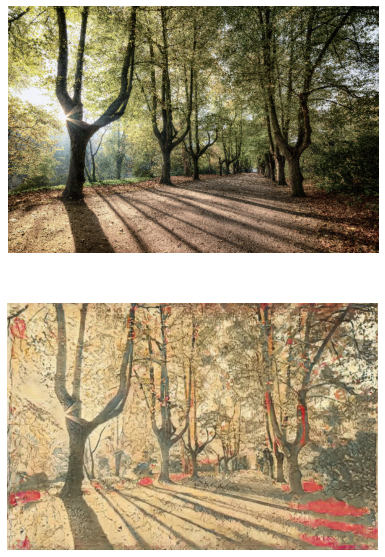

In [26]:
show_image_tensors(
    [
        DENORMALIZE_T(A),
        DENORMALIZE_T(visuals["fake"].cpu()),
    ]
)

In [27]:
save_image_tensor_to_url(styled_image_tensor[0], STYLED_IMAGE_PATH_OR_URL)